# USING WINDOW SLIDER 
#### By - Arnav Ahuja (223271095)

## Loading data

In [2]:
import pandas as pd

def load_data(csv_file):
    """
    Loads time series data from a CSV file, assumes the first column contains 
    date/time or sequential information, replaces it with numeric indices, 
    and returns the processed DataFrame along with the index range and time column name.
    
    Parameters:
        csv_file (str): Path to the CSV file.

    Returns:
        df (pd.DataFrame): DataFrame with 'data_point' as the time/index column.
        min_dp (int): Minimum value of the data point index.
        max_dp (int): Maximum value of the data point index.
        time_col (str): Name of the new time/index column ('data_point').
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Rename the first column to 'data_point' and replace with sequential indices
    original_time_col = df.columns[0]
    df.rename(columns={original_time_col: "data_point"}, inplace=True)
    df["data_point"] = list(range(len(df)))
    
    # Get the minimum and maximum values for the data point index
    min_dp = df["data_point"].min()
    max_dp = df["data_point"].max()
    
    return df, min_dp, max_dp, "data_point"

## Normalizing data

In [5]:
import numpy as np

def normalize_data(df, time_col="data_point"):
    """
    Cleans and normalizes sensor data in a DataFrame:
      - Drops completely empty rows and columns.
      - Interpolates missing values in numeric columns.
      - Returns only numeric sensor columns along with the time column.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing time and sensor streams.
        time_col (str): The name of the time/index column (default is 'data_point').

    Returns:
        pd.DataFrame: A new DataFrame with interpolated and cleaned numeric columns.
    """
    df = df.copy()
    df.dropna(how='all', inplace=True)  # Drop rows where all values are NaN
    df.dropna(axis=1, how='all', inplace=True)  # Drop columns where all values are NaN
    
    # Identify sensor columns (all columns except the time column)
    sensor_cols = [col for col in df.columns if col != time_col]
    
    # Keep only numeric columns among the sensor columns
    numeric_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()
    
    # Fill missing numeric values using linear interpolation
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')
    
    # Drop any remaining NaNs after interpolation, if they still exist
    df.dropna(how='any', inplace=True)
    
    return df[[time_col] + numeric_cols]


## Calculating Sliding Correlation

In [8]:
def compute_sliding_correlations(df, window_size, time_col="data_point"):
    """
    Calculates and returns sliding window correlations between sensor streams.

    Parameters:
        df (pd.DataFrame): DataFrame containing sensor data.
        window_size (int): Size of the sliding window.
        time_col (str): Name of the time column.

    Returns:
        correlations (dict): Dictionary with correlations between stream pairs.
    """
    stream_cols = df.columns.drop(time_col)
    correlations = {}

    # Compute correlations for each pair of streams
    for i in range(len(stream_cols)):
        for j in range(i + 1, len(stream_cols)):
            pair = (stream_cols[i], stream_cols[j])
            corrs = []
            for start in range(0, len(df) - window_size + 1):
                window = df.iloc[start:start + window_size]
                corr = window[stream_cols[i]].corr(window[stream_cols[j]])
                corrs.append(corr)
            correlations[pair] = corrs
    return correlations

## Saving Correlations into CSV

In [11]:
import os

def save_correlations(df, correlations, output_dir, time_col="data_point"):
    """
    Saves a new CSV file in the same folder as the original with rolling correlations added.

    Parameters:
        correlations (dict): Dictionary containing rolling correlations for sensor pairs.
        output_dir (str): Folder path where the original file was located.
        time_col (str): Name of the time/index column.
    """
    df_to_save = df.copy()  # Assumes df_normalized is available in scope

    # Add correlation columns with appropriate names like c(1, 2)
    for (s1, s2), corr_values in correlations.items():
        col_name = f"c({s1[-1]}, {s2[-1]})"
        padded_corr = [None] * (len(df_to_save) - len(corr_values)) + corr_values
        df_to_save[col_name] = padded_corr

    # Save to the same directory as complex.csv with a new name
    output_path = os.path.join(output_dir, "complex_formatted.csv")
    df_to_save.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

## Plotting data

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_correlation(df, correlations, window_size, time_col="data_point"):
    """
    Plots the selected sensor streams along with their correlations over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time column and sensor data.
        correlations (dict): Dictionary with correlation values for each stream pair.
        window_size (int): Size of the sliding window used for correlations.
        time_col (str): Name of the time column.
    """
    stream_cols = df.columns.drop(time_col)
    t = df[time_col].values

    # Loop through each pair of streams and plot the data and correlation
    for (s1, s2), corr_values in correlations.items():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(t, df[s1], label=s1)
        ax.plot(t, df[s2], label=s2)

        corr_x = np.arange(window_size - 1, len(df))
        corr_plot = np.full(len(df), np.nan)
        corr_plot[window_size - 1:] = corr_values
        ax.plot(t, corr_plot, label=f"Correlation({s1},{s2})", color='red')

        ax.set_title(f"Time Series & Correlation: {s1} & {s2}")
        ax.set_xlabel("Data Point")
        ax.set_ylabel("Normalized Values")
        ax.legend()

        fig.tight_layout()
        plt.show()

## Setting up GUI

In [17]:
import tkinter as tk
from tkinter import ttk
from datetime import datetime

def setup_gui(min_dp, max_dp, sensor_columns, process_callback):
    """
    Sets up the Tkinter GUI for selecting window size and stream types.
    The stream selection checkboxes are generated dynamically based on the available sensor columns.

    Parameters:
        min_dp (int): Minimum value of the data point index.
        max_dp (int): Maximum value of the data point index.
        sensor_columns (list): List of available sensor stream column names.
        process_callback (function): Function to call when the Display button is clicked.

    Returns:
        root (tk.Tk): The root window of the Tkinter interface.
    """
    root = tk.Tk()
    root.title("Window Size & Stream Selector + Normalization")
    root.geometry("500x300")
    root.configure(bg="#f9f9f9")

    style = ttk.Style()
    style.configure("TLabel", font=("Segoe UI", 10, "bold"), background="#f9f9f9")
    style.configure("TButton", font=("Segoe UI", 10))
    style.configure("TCheckbutton", font=("Segoe UI", 10), background="#f9f9f9")

    # Window Size Label and Entry
    ttk.Label(root, text="Window Size:").grid(row=0, column=0, padx=10, pady=10)
    window_entry = ttk.Entry(root, width=10)
    window_entry.insert(0, "15")
    window_entry.grid(row=0, column=1, sticky="w")

    # Window Size Slider
    window_slider = tk.Scale(root, from_=1, to=max_dp, orient=tk.HORIZONTAL, length=250, bg="#f9f9f9")
    window_slider.set(15)
    window_slider.grid(row=1, column=0, columnspan=3, padx=10)

    def sync_slider_and_entry(*args):
        try:
            val = int(window_entry.get())
            if 1 <= val <= max_dp:
                window_slider.set(val)
        except ValueError:
            pass

    def sync_entry_and_slider(val):
        window_entry.delete(0, tk.END)
        window_entry.insert(0, str(int(float(val))))

    window_entry.bind("<KeyRelease>", lambda e: sync_slider_and_entry())
    window_slider.config(command=sync_entry_and_slider)

    # Dynamic Stream Selection
    ttk.Label(root, text="Select Streams:").grid(row=2, column=0, padx=10, pady=10)
    stream_vars = {}
    for idx, stream in enumerate(sensor_columns):
        var = tk.BooleanVar(value=True)
        chk = ttk.Checkbutton(root, text=stream, variable=var)
        chk.grid(row=2 + idx // 3, column=1 + idx % 3, sticky="w", padx=5)
        stream_vars[stream] = var

    # Display Button
    def on_click():
        try:
            window_size = int(window_entry.get())
            if 1 <= window_size <= max_dp:
                process_callback(window_size, stream_vars)
            else:
                print("Invalid window size")
        except ValueError:
            print("Please enter a valid integer for window size.")

    ttk.Button(root, text="Display", command=on_click).grid(row=3, columnspan=4, pady=20)

    return root

## Callback function

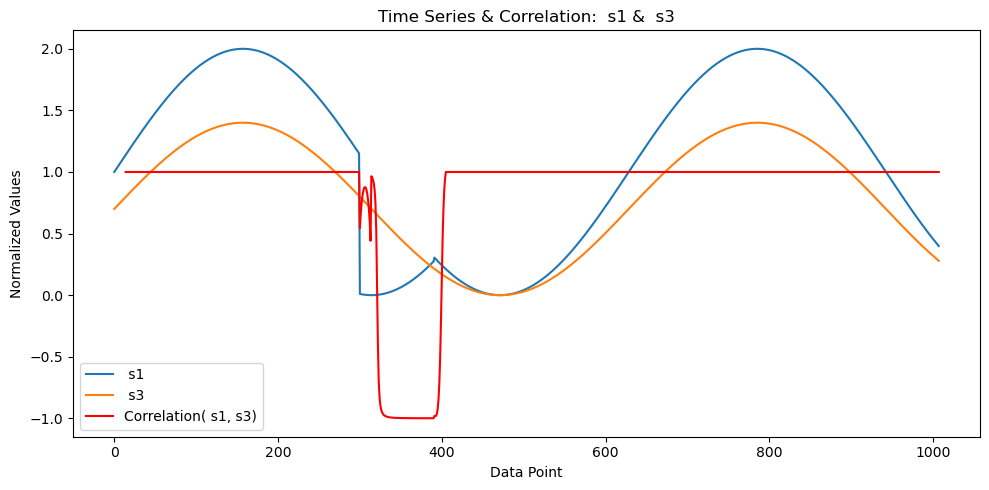

Saved: complex_formatted.csv


In [20]:
def process_callback(window_size, stream_vars):
    """
    Processes the data and generates sliding window correlations and plots based on user input.

    Parameters:
        window_size (int): Size of the sliding window.
        stream_vars (dict): Dictionary of selected streams and their BooleanVar values.
    """
    selected_columns = ["data_point"]
    
    # Dynamically add the selected streams to the selected_columns list
    for stream, var in stream_vars.items():
        if var.get():  # If the stream is selected (checked)
            selected_columns.append(stream)
    
    # Select the columns from the DataFrame based on user selection
    df_selected = df_raw[selected_columns]
    
    # Normalize the selected data
    df_normalized = normalize_data(df_selected, time_col="data_point")
    
    # Calculate the sliding window correlations
    correlations = compute_sliding_correlations(df_normalized, window_size, time_col="data_point")
    
    # Plot the data and correlations
    plot_with_correlation(df_normalized, correlations, window_size, time_col="data_point")

    # Save correlations to JSON and CSV in same folder as input file
    save_correlations(df_normalized, correlations, output_dir=os.path.dirname("complex.csv"))

if __name__ == "__main__":
    # Load data from the specified file
    df_raw, min_dp, max_dp, time_col = load_data("complex.csv")  # Replace with your dataset

    # Get the list of sensor columns (excluding the time column)
    sensor_columns = [col for col in df_raw.columns if col != time_col]
    
    # Set up and launch the GUI
    root = setup_gui(min_dp, max_dp, sensor_columns, process_callback)
    root.mainloop()
